In [90]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# for KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score

In [4]:
diabetes_code = set([253,357,588,648,775])
seed = 1234

In [5]:
def read_data():
    data = pd.read_csv('diabetic_data.csv')
    return data

In [82]:
def extract_data(data):
    basic_data = data[['race','age','gender','diag_1']]
    # print(np.unique(basic_data['diag_1']))
    basic_data = basic_data[basic_data['diag_1'] != '?']
    #change y labels to 1 if in diabetes code else no
    basic_data['diag_1'] = basic_data['diag_1'].apply(lambda x: 1 if x.startswith("250") else 0)
    diabetic_data = basic_data[basic_data['diag_1'] == 1]
    non_diabetic_data = basic_data[basic_data['diag_1'] == 0]
    non_diabetic_data = non_diabetic_data.sample(n=len(diabetic_data), random_state=1234)
    balanced_data = pd.concat([diabetic_data, non_diabetic_data])
    race = balanced_data[['race']]
    other = balanced_data[['age','gender','diag_1']]
    
    # print(len(basic_data[basic_data['diag_1'] == 1]))
    # print(len(basic_data))
    
    imp = SimpleImputer(missing_values='?', strategy="constant", fill_value="Other")
    clean_race = imp.fit_transform(race)
    # print(len(clean_race))
    np_data = other.to_numpy()
    # print(np_data)
    clean_data = np.concatenate((clean_race, np_data),axis=1)
    print(clean_data)
    #add other stuff here for other types of data needed to extract
    return clean_data

In [83]:
data = read_data()
basic = extract_data(data)

[['Caucasian' '[0-10)' 'Female' 1]
 ['AfricanAmerican' '[40-50)' 'Female' 1]
 ['AfricanAmerican' '[40-50)' 'Female' 1]
 ...
 ['Hispanic' '[50-60)' 'Male' 0]
 ['Caucasian' '[90-100)' 'Male' 0]
 ['Caucasian' '[40-50)' 'Female' 0]]


<h1> KNN Classifier </h1>

In [105]:
# def encode_features(features):
#     le = LabelEncoder()
#     oe = OrdinalEncoder(categories=[['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']])
#     features[:,0] = le.fit_transform(features[:,0])
#     features[:,1] = oe.fit_transform(features[:,1].reshape(-1,1))
#     features[:,2] = le.fit_transform(features[:,2])
#     return features

def encode_features(features):
    le_race = LabelEncoder()
    le_gender = LabelEncoder()
    oe_age = OrdinalEncoder(categories=[['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']])

    features[:, 0] = le_race.fit_transform(features[:, 0])
    features[:, 1] = oe_age.fit_transform(features[:, 1].reshape(-1, 1)).flatten()
    features[:, 2] = le_gender.fit_transform(features[:, 2])
    return features, le_race, oe_age, le_gender

#print(basic[:, 0:3])
features, le_race, oe_age, le_gender = encode_features(basic[:, 0:3].copy())
#print(features)
diag = basic[:,3].astype(int)
knnx_train, knnx_test, knny_train, knny_test = train_test_split(features, diag, test_size=0.2, random_state=seed)
print(knny_train)


[0 1 1 ... 1 0 1]


In [110]:
# train on race and age
knnx_train_1 = knnx_train[:, 0:2]

#train on race and gender
knnx_train_2 = knnx_train[:, [0, 2]]
print(knnx_train_2)

#train on age and gender
knnx_train_3 = knnx_train[:, 1:3]

# test on race and age
knnx_test_1 = knnx_test[:, 0:2]

# test on race and gender
knnx_test_2 = knnx_test[:, [0, 2]]

# test on age gender
knnx_test_3 = knnx_test[:, 1:3]

[[0 1]
 [3 0]
 [0 1]
 ...
 [2 1]
 [2 1]
 [2 0]]


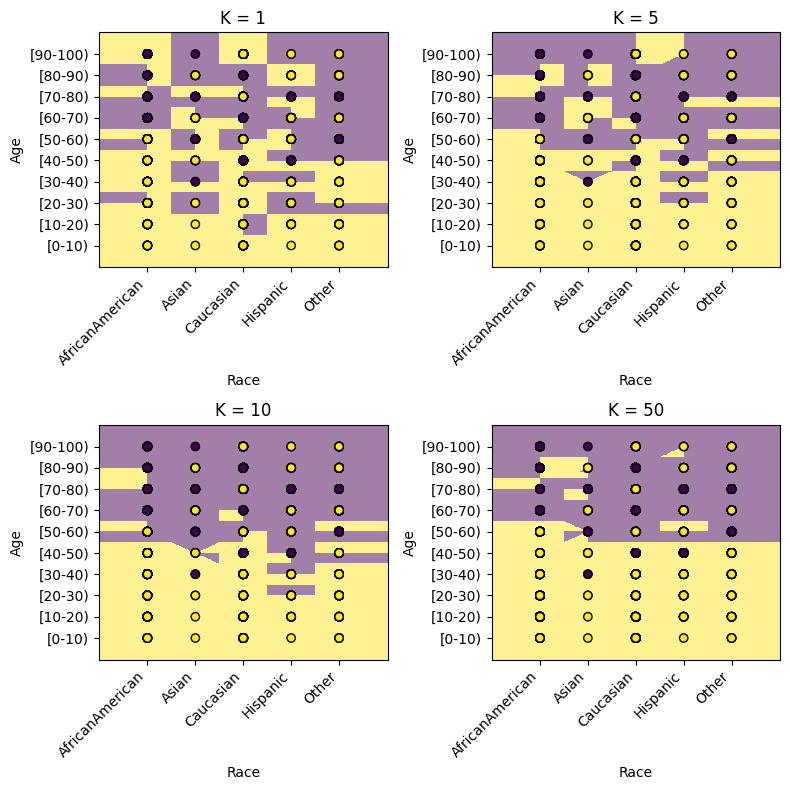

In [107]:

# KNN for race and age
plot_kwargs = {'cmap': 'viridis',
               'response_method': 'predict',
               'plot_method': 'pcolormesh',
               'shading': 'auto',
               'alpha': 0.5,
               'grid_resolution': 300}

figure, axes = plt.subplots(2, 2, figsize=(8, 8))
k_values = [1, 5, 10, 50]


for k, ax in zip(k_values, axes.flatten()):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(knnx_train_1, knny_train)

    display = DecisionBoundaryDisplay.from_estimator(knn, knnx_train_1, ax=ax, **plot_kwargs)

    ax.scatter(knnx_train_1[:, 0], knnx_train_1[:, 1], c=knny_train, edgecolor='k', cmap=plot_kwargs['cmap'])
    ax.set_xlabel('Race')
    ax.set_ylabel('Age')
    ax.set_title(f'K = {k}')

    age_decode = np.arange(len(oe_age.categories_[0]))
    age_labels = oe_age.categories_[0]
    ax.set_yticks(age_decode)
    ax.set_yticklabels(age_labels)

    race_decode = np.arange(len(le_race.classes_))
    race_labels = le_race.classes_
    ax.set_xticks(race_decode)
    ax.set_xticklabels(race_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

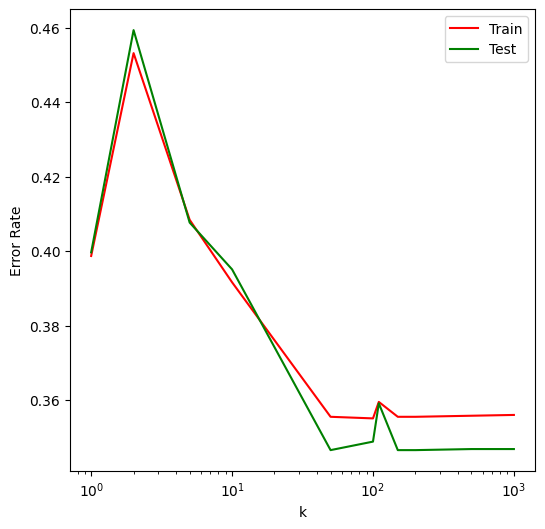

Minimum error rate: 0.3465600913502712 at k = 50


In [108]:
# Error rate for race and age
# Create a figure with only one subplot
figure, axes = plt.subplots(1, figsize=(6, 6))

### YOUR CODE STARTS HERE ###

train_error_rates = []
test_error_rates = []

k_values = [1, 2, 5, 10, 50, 100, 110, 150, 200, 500, 1000]

minerror = 1
minerror_k = 0

for idx, k in enumerate(k_values):
    knn = KNeighborsClassifier(k)
    knn.fit(knnx_train_1, knny_train)
    
    train_pred = knn.predict(knnx_train_1)
    test_pred = knn.predict(knnx_test_1)
    
    train_error = 1 - accuracy_score(knny_train, train_pred)
    test_error = 1 - accuracy_score(knny_test, test_pred)

    train_error_rates.append(train_error)
    test_error_rates.append(test_error)

    if test_error < minerror:
        minerror = test_error
        minerror_k = k

axes.semilogx(k_values, train_error_rates, color='red', label='Train')
axes.semilogx(k_values, test_error_rates, color='green', label='Test')

axes.set_xlabel('k')
axes.set_ylabel('Error Rate')
axes.legend()

#plt.tight_layout()
plt.show()
print(f'Minimum error rate: {minerror} at k = {minerror_k}')

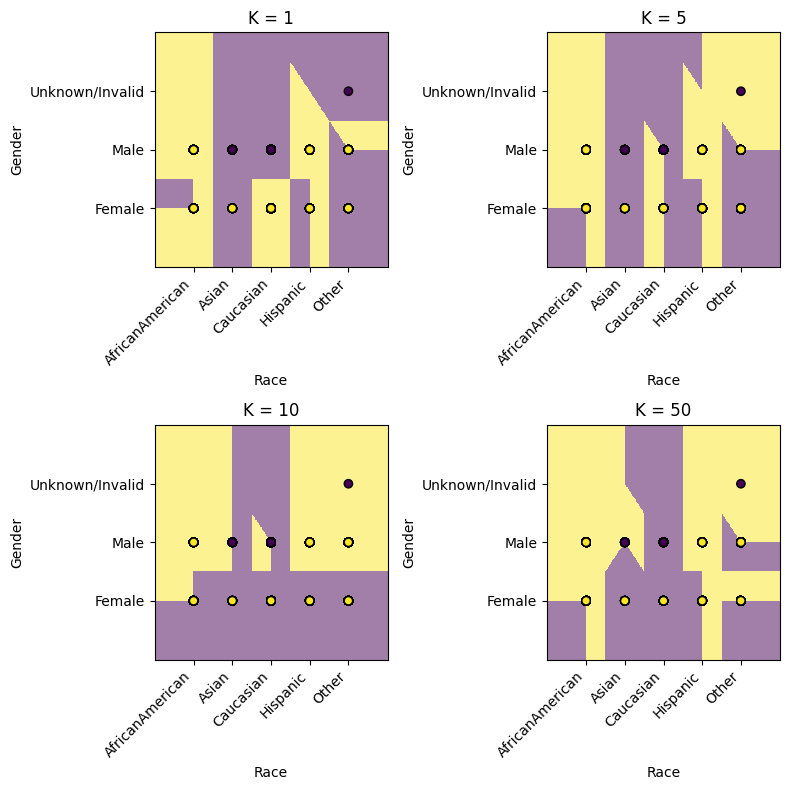

In [114]:

# KNN for race and gender
plot_kwargs = {'cmap': 'viridis',
               'response_method': 'predict',
               'plot_method': 'pcolormesh',
               'shading': 'auto',
               'alpha': 0.5,
               'grid_resolution': 300}

figure, axes = plt.subplots(2, 2, figsize=(8, 8))
k_values = [1, 5, 10, 50]


for k, ax in zip(k_values, axes.flatten()):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(knnx_train_2, knny_train)

    display = DecisionBoundaryDisplay.from_estimator(knn, knnx_train_2, ax=ax, **plot_kwargs)

    ax.scatter(knnx_train_2[:, 0], knnx_train_2[:, 1], c=knny_train, edgecolor='k', cmap=plot_kwargs['cmap'])
    ax.set_xlabel('Race')
    ax.set_ylabel('Gender')
    ax.set_title(f'K = {k}')

    race_decode = np.arange(len(le_race.classes_))
    race_labels = le_race.classes_
    ax.set_xticks(race_decode)
    ax.set_xticklabels(race_labels, rotation=45, ha='right')

    gender_decode = np.arange(len(le_gender.classes_))
    gender_labels = le_gender.classes_
    ax.set_yticks(gender_decode)
    ax.set_yticklabels(gender_labels)

plt.tight_layout()
plt.show()

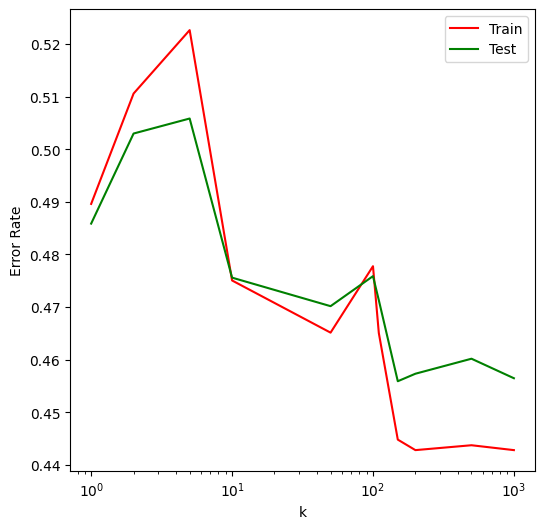

Minimum error rate: 0.4558949471881245 at k = 150


In [117]:
# Error rate for race and gender
figure, axes = plt.subplots(1, figsize=(6, 6))

train_error_rates = []
test_error_rates = []

k_values = [1, 2, 5, 10, 50, 100, 110, 150, 200, 500, 1000]

minerror = 1
minerror_k = 0

for idx, k in enumerate(k_values):
    knn = KNeighborsClassifier(k)
    knn.fit(knnx_train_2, knny_train)

    train_pred = knn.predict(knnx_train_2)
    test_pred = knn.predict(knnx_test_2)

    train_error = 1 - accuracy_score(knny_train, train_pred)
    test_error = 1 - accuracy_score(knny_test, test_pred)

    train_error_rates.append(train_error)
    test_error_rates.append(test_error)

    if test_error < minerror:
        minerror = test_error
        minerror_k = k

axes.semilogx(k_values, train_error_rates, color='red', label='Train')
axes.semilogx(k_values, test_error_rates, color='green', label='Test')

axes.set_xlabel('k')
axes.set_ylabel('Error Rate')
axes.legend()

#plt.tight_layout()
plt.show()
print(f'Minimum error rate: {minerror} at k = {minerror_k}')

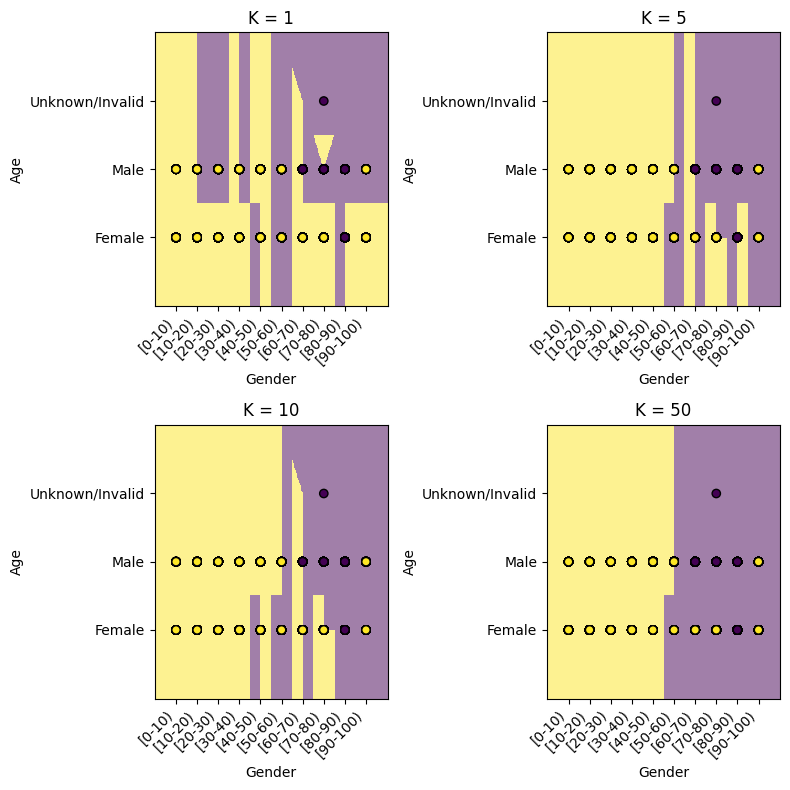

In [122]:

# KNN for age and gender
plot_kwargs = {'cmap': 'viridis',
               'response_method': 'predict',
               'plot_method': 'pcolormesh',
               'shading': 'auto',
               'alpha': 0.5,
               'grid_resolution': 300}

figure, axes = plt.subplots(2, 2, figsize=(8, 8))
k_values = [1, 5, 10, 50]


for k, ax in zip(k_values, axes.flatten()):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(knnx_train_3, knny_train)

    display = DecisionBoundaryDisplay.from_estimator(knn, knnx_train_3, ax=ax, **plot_kwargs)

    ax.scatter(knnx_train_3[:, 0], knnx_train_3[:, 1], c=knny_train, edgecolor='k', cmap=plot_kwargs['cmap'])
    ax.set_title(f'K = {k}')

    gender_decode = np.arange(len(le_gender.classes_))
    gender_labels = le_gender.classes_
    ax.set_yticks(gender_decode)
    ax.set_yticklabels(gender_labels)

    age_decode = np.arange(len(oe_age.categories_[0]))
    age_labels = oe_age.categories_[0]
    ax.set_xticks(age_decode)
    ax.set_xticklabels(age_labels,rotation=45, ha='right')

    ax.set_xlabel('Gender')
    ax.set_ylabel('Age')

plt.tight_layout()
plt.show()

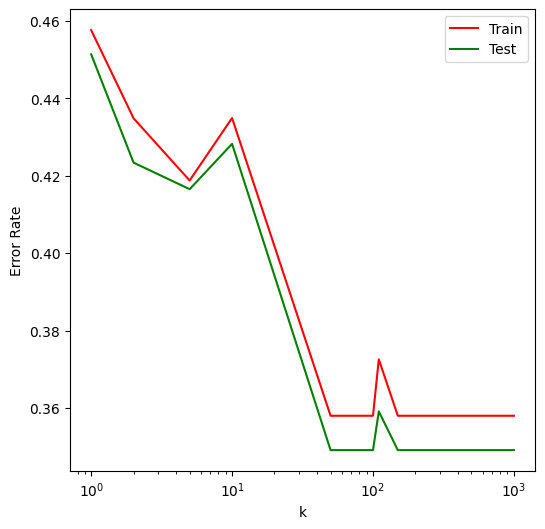

Minimum error rate: 0.349129317727662 at k = 50


In [123]:
# Error rate for race and gender
figure, axes = plt.subplots(1, figsize=(6, 6))

train_error_rates = []
test_error_rates = []

k_values = [1, 2, 5, 10, 50, 100, 110, 150, 200, 500, 1000]

minerror = 1
minerror_k = 0

for idx, k in enumerate(k_values):
    knn = KNeighborsClassifier(k)
    knn.fit(knnx_train_3, knny_train)

    train_pred = knn.predict(knnx_train_3)
    test_pred = knn.predict(knnx_test_3)

    train_error = 1 - accuracy_score(knny_train, train_pred)
    test_error = 1 - accuracy_score(knny_test, test_pred)

    train_error_rates.append(train_error)
    test_error_rates.append(test_error)

    if test_error < minerror:
        minerror = test_error
        minerror_k = k

axes.semilogx(k_values, train_error_rates, color='red', label='Train')
axes.semilogx(k_values, test_error_rates, color='green', label='Test')

axes.set_xlabel('k')
axes.set_ylabel('Error Rate')
axes.legend()

#plt.tight_layout()
plt.show()
print(f'Minimum error rate: {minerror} at k = {minerror_k}')

<h1>Neural Networks</h1>

In [8]:
def startData(data, start, end):  #input is df
    # data = data.to_numpy()
    # print(type(data))
    # print(len(data))
    # valid_idx = y.__index__
    # X = preprocess_data(data[:,start:end])  #get first three cols of data
    r = data[:,0]
    print(r.reshape(1,-1))
    gender = data[:,2]
    print(gender)
    X = preprocess_data(np.hstack([r.reshape(len(data),1),gender.reshape(len(data),1)]))
    # y = preprocess_label(data[:,3])  #get last col = diagnosis
    y = np.array(data[:,3]).astype(int)
    # print(type(y))    #ndarray
    print(X)
    print(y)
    X_tr, y_tr, X_va, y_va, X_te, y_te = separateData(X,y)  #
    # print(y_tr)
    return X_tr, y_tr, X_va, y_va, X_te, y_te

def separateData(X_data, y_data):
    X_temp, X_te, y_temp, y_te = train_test_split(X_data, y_data, test_size=0.2 ,random_state=1234, shuffle=True)
    X_tr, X_va, y_tr, y_va = train_test_split(X_temp, y_temp, test_size=0.15 ,shuffle=True, random_state=1234)
    return X_tr, y_tr, X_va, y_va, X_te, y_te
    
def preprocess_data(data):
    # data.replace('?',"other",inplace=True)
    print(data)
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(data)
    return encoded_data

def preprocess_label(labels):
    # labels = labels[labels != '?']
    print("original", labels)
    lb = LabelBinarizer()
    binary_label = lb.fit_transform(labels)
    return binary_label

In [9]:
X_tr, y_tr, X_va, y_va, X_te, y_te = startData(basic,1,3)

[['Caucasian' 'AfricanAmerican' 'AfricanAmerican' ... 'Hispanic'
  'Caucasian' 'Caucasian']]
['Female' 'Female' 'Female' ... 'Male' 'Male' 'Female']
[['Caucasian' 'Female']
 ['AfricanAmerican' 'Female']
 ['AfricanAmerican' 'Female']
 ...
 ['Hispanic' 'Male']
 ['Caucasian' 'Male']
 ['Caucasian' 'Female']]
[[0. 0. 1. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 1. 0. 0.]]
[1 1 1 ... 0 0 0]


In [10]:
def get_learning_curve(classifier, X, y):
    train_size_abs, train_scores, test_scores = learning_curve(
    classifier, X, y, train_sizes=[0.3, 0.6, 0.9]
    )
    for train_size, cv_train_scores, cv_test_scores in zip(
        train_size_abs, train_scores, test_scores
    ):
        print(f"{train_size} samples were used to train the model")
        print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
        print(f"The average test accuracy is {cv_test_scores.mean():.2f}")

In [11]:
def errors_for_train_sizes_mlp(X_tr: np.array, y_tr: np.array, X_va:np.array, y_va: np.array, X_te: np.array, y_te: np.array, seed: int, train_sizes: list[int]) -> tuple[list, list, list, list]:
    # append error rates to the following lists
    tr_err_mlp = [] # training error rates for MLP
    va_err_mlp = [] #validation error rattes for MLP
    te_err_mlp = [] # testing error rates for MLP

    ### YOUR CODE STARTS HERE ###
    mlp = MLPClassifier(hidden_layer_sizes=64, solver='sgd', batch_size=256,random_state=seed)
    # get_learning_curve(mlp, X_tr, y_tr)
    #for loop
    for i in train_sizes:
        # print(X_tr)
        # print(y_tr)
        mlp.fit(X_tr[:i],y_tr[:i])
        # res = mlp.predict(X_tr[:i])
        tr_err_mlp.append(1-mlp.score(X_tr[:i],y_tr[:i]))
        # print(tr_err_mlp)
        va_err_mlp.append(1-mlp.score(X_va[:i],y_va[:i]))
        # res = mlp.predict(X_te[:i])
        te_err_mlp.append(1-mlp.score(X_te[:i],y_te[:i]))
        # print(X_tr[:i])
        # print(y_tr[:i])
    print(tr_err_mlp)
    print(va_err_mlp)
    print(te_err_mlp)
    # print(X_tr[:50])
    ###  YOUR CODE ENDS HERE  ###
    return tr_err_mlp, va_err_mlp, te_err_mlp # DO NOT CHANGE THIS LINE    

In [12]:
def plot_errors_for_train_sizes_mlp_lr(tr_err_mlp: list, te_err_mlp: list, va_err_mlp: list, train_sizes: list[int]) -> None:
    ### YOUR CODE STARTS HERE ###
    # Please use semilogx to plot
    plt.semilogx(train_sizes,tr_err_mlp,label='MLP Training Error')
    plt.semilogx(train_sizes,te_err_mlp,label='MLP Testing Error')
    plt.semilogx(train_sizes,va_err_mlp,label='MLP Validation Error')

    plt.xlabel('Num. Training Data Points')
    plt.ylabel('Error Rate')

    plt.legend()
    ###  YOUR CODE ENDS HERE  ###

In [13]:
def errors_for_learning_rates_mlp(X_tr: np.array, y_tr: np.array, seed: int, learning_rates: list[float]) -> list[list]:
    err_curves = [] # append loss_curve_ from each MLP model to this list
    ### YOUR CODE STARTS HERE ###
    # MAKE SURE YOU ARE USING THE GIVEN ARGUMENT NAMES
    
    for l in learning_rates:
        mlp = MLPClassifier(hidden_layer_sizes=64, solver='sgd',max_iter=100,
                        n_iter_no_change=100,random_state=seed,batch_size=256, learning_rate_init=l)
        mlp.fit(X_tr,y_tr)
        err_curves.append(mlp.loss_curve_)
    ###  YOUR CODE ENDS HERE  ###
    return err_curves

In [14]:
def plot_errors_for_learning_rates_mlp(err_curves: list[list], learning_rates: list[float]) -> None:
    ### YOUR CODE STARTS HERE ###
    for i, curve in enumerate(err_curves):
        plt.plot(curve,label=learning_rates[i])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    ###  YOUR CODE ENDS HERE  ###

c:\Users\julia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


[0.42000000000000004, 0.472, 0.43600000000000005, 0.4456, 0.4423, 0.443110252750021, 0.443110252750021]
[0.54, 0.472, 0.4585, 0.456232159847764, 0.45147478591817314, 0.456232159847764, 0.456232159847764]
[0.52, 0.504, 0.45799999999999996, 0.4604624607479303, 0.45760776477305165, 0.4604624607479303, 0.4604624607479303]


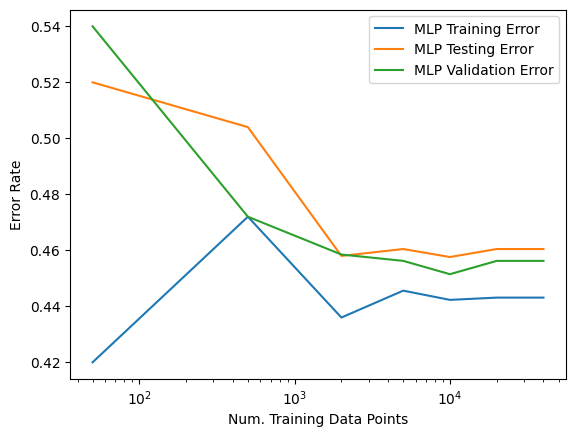

In [15]:
train_sizes = [50, 500, 2000, 5000, 10000, 20000, 40000]
# train_sizes = [50, 500]
# print(X_tr)
tr_err_mlp, va_err_mlp, te_err_mlp = errors_for_train_sizes_mlp(X_tr, y_tr, X_va, y_va, X_te, y_te, seed, train_sizes)
plot_errors_for_train_sizes_mlp_lr(tr_err_mlp, te_err_mlp, va_err_mlp, train_sizes)

C:\Users\MatthewChang\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\MatthewChang\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\MatthewChang\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\MatthewChang\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.wa

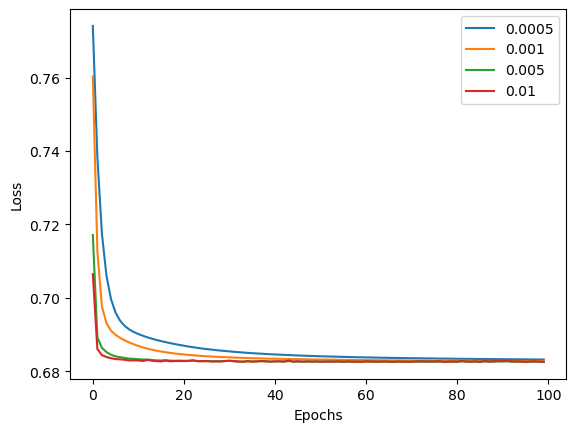

In [143]:
learning_rates = [0.0005, 0.001, 0.005, 0.01]
curves = errors_for_learning_rates_mlp(X_tr, y_tr, seed, learning_rates)
plot_errors_for_learning_rates_mlp(curves, learning_rates)